In [2]:
import timesfm

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
import ast

from datetime import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [35]:
print("Loading data file now, this could take a while depending on file size")
start = time.time()
df = pd.read_csv('co2_data.csv')
end = time.time()
print("Loading took " + str(round(end - start, 2)) + " seconds")

Loading data file now, this could take a while depending on file size
Loading took 0.0 seconds


In [33]:
timesfm_backend = "gpu"  

model = timesfm.TimesFm(  
    hparams=timesfm.TimesFmHparams( 
        backend=timesfm_backend,  # ระบุ backend ที่ใช้ เช่น GPU (ค่าถูกกำหนดจากตัวแปร timesfm_backend)
        per_core_batch_size=32,  # ขนาดของ batch ต่อ core ที่ใช้ใน data parallelism (กระบวนการประมวลผลขนาน)
        horizon_len=16,  # ความยาวของช่วงเวลาที่โมเดลจะทำนายล่วงหน้า (forecast horizon)
        num_layers=50,  # จำนวนชั้น (layers) ของ Transformer ในโมเดล
        use_positional_embedding=False,  # ระบุว่าจะใช้ positional embedding หรือไม่ (False แปลว่าไม่ใช้)
        context_len=32,  # ความยาวของบริบท (context length) ที่โมเดลสามารถรับข้อมูลในแต่ละครั้ง
    ),
    checkpoint=timesfm.TimesFmCheckpoint(  # กำหนด checkpoint สำหรับโหลดน้ำหนักที่ผ่านการฝึกฝนแล้ว
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"  # ไฟล์น้ำหนักโมเดลจาก repository Hugging Face
    ),
)


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


In [36]:
df['ds'] = pd.date_range(start=pd.to_datetime(df['Year'], format='%Y').min(), periods=len(df), freq='W')
df.drop(columns=['Year','Year&Month'], inplace=True)
df.head()

,CO2,ds
0,333.13,1974-01-06
1,332.09,1974-01-13
2,331.10,1974-01-20
3,329.14,1974-01-27
4,327.36,1974-02-03


In [37]:
df['unique_id'] = range(1, len(df) + 1)
df.head()

,CO2,ds,unique_id
0,333.13,1974-01-06,1
1,332.09,1974-01-13,2
2,331.10,1974-01-20,3
3,329.14,1974-01-27,4
4,327.36,1974-02-03,5


In [38]:
df.rename(columns={'CO2':'y'}, inplace=True)

In [39]:
df

,y,ds,unique_id
0,333.13,1974-01-06,1
1,332.09,1974-01-13,2
2,331.10,1974-01-20,3
3,329.14,1974-01-27,4
4,327.36,1974-02-03,5
...,...,...,...
156,351.71,1977-01-02,157
157,350.94,1977-01-09,158
158,349.10,1977-01-16,159
159,346.77,1977-01-23,160


In [40]:
forecast_df = model.forecast_on_df(
    inputs=df,
    freq="W",  # monthly
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [41]:
def plot_levels_overtime(df=df, x_column=None, y_column=None):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_column], df[y_column], marker='o', markersize=5, markerfacecolor='red', color='blue', label=y_column)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f"{y_column} Levels Over Time")
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [42]:
forecast_df

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,1974-01-13,333.122345,332.165924,332.596527,332.826477,332.987244,333.122345,333.257294,333.419189,333.654663,334.083435
1,1,1974-01-20,333.120880,332.083527,332.530609,332.777924,332.961243,333.120880,333.281677,333.465973,333.717102,334.158844
2,1,1974-01-27,333.121826,332.058960,332.499878,332.751465,332.948883,333.121826,333.299561,333.496521,333.749969,334.185883
3,1,1974-02-03,333.121735,332.051636,332.491302,332.743347,332.939301,333.121735,333.303894,333.503723,333.759308,334.192444
4,1,1974-02-10,333.118530,332.056915,332.487793,332.734436,332.932159,333.118530,333.306305,333.505493,333.756195,334.183838
...,...,...,...,...,...,...,...,...,...,...,...,...
2571,161,1977-04-24,345.714813,344.746857,345.124115,345.348846,345.536011,345.714813,345.894165,346.085663,346.311584,346.687012
2572,161,1977-05-01,345.715698,344.732483,345.116364,345.339478,345.531555,345.715698,345.901489,346.097290,346.322845,346.706024
2573,161,1977-05-08,345.716156,344.723938,345.109253,345.333618,345.527496,345.716156,345.908813,346.106293,346.335144,346.716858
2574,161,1977-05-15,345.721619,344.737549,345.118317,345.339935,345.532471,345.721619,345.915802,346.110870,346.337799,346.713226


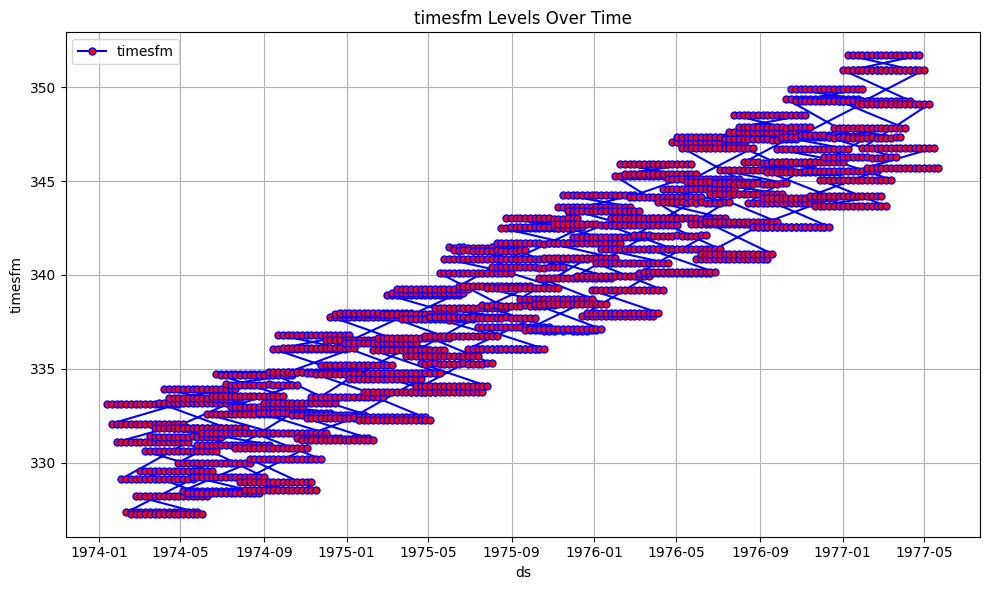

In [43]:
plot_levels_overtime(df=forecast_df, x_column='ds', y_column='timesfm')